## Importing File

In [2]:
import pandas as pd
import numpy as np
path = 'data/df5.csv'
df = pd.read_csv(path)

cfw_outlet_temp=[i for i in df.columns if i.endswith('CFW_OUTLET_TEMP')]
exh_gas_outlet_temp=[i for i in df.columns if i.endswith('EXH_GAS_OUTLET_TEMP')]
df['ME1_CYL_CFW_OUTLET_TEMP']=df[cfw_outlet_temp].apply(np.mean,axis=1)
df['ME1_CYL_EXH_GAS_OUTLET_TEMP']=df[cfw_outlet_temp].apply(np.mean,axis=1)
df=df.drop(cfw_outlet_temp,axis='columns')
df=df.drop(exh_gas_outlet_temp,axis='columns')
df=(df - df.mean())/df.std()

## Making First Ensemble Set

In [3]:
!pip install pyod

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [4]:
# Importing possible approaches
from pyod.models.lof import LOF

In [19]:
from pyod.models.lscp import LSCP
from pyod.models.knn import KNN
detectorList=[]
k = np.random.choice(range(5,150),31,replace=False)
print(k)
for i in k:
    # detectorList.append(LOF(i))
    detectorList.append(KNN(n_neighbors=i, n_jobs=-1))
clf=LSCP(detectorList)
clf.fit(df)


[ 45 128 133  42 148 149  81  75 145 136  98 137  58 114 117  72  64  87
  97  79  76 135 119   6  43 139 144 104 132 123  67]


LSCP(contamination=0.1,
   detector_list=[KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=-1, n_neighbors=45, p=2,
  radius=1.0), KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=-...='largest',
  metric='minkowski', metric_params=None, n_jobs=-1, n_neighbors=67, p=2,
  radius=1.0)],
   local_max_features=1.0, local_region_size=30, n_bins=10,
   random_state=RandomState(MT19937) at 0x7FAEA00B5258)

## Anomaly Score Analysis

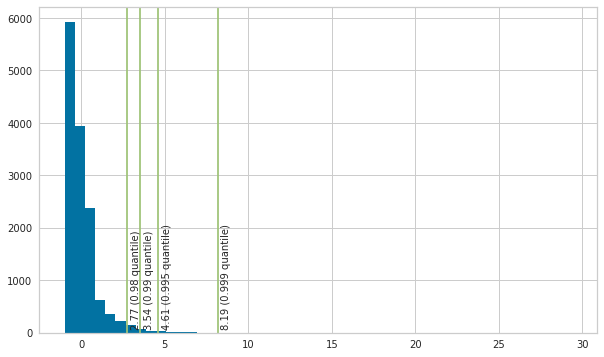

In [73]:
import matplotlib.pyplot as plt
anomalyScore=clf.decision_scores_
plt.figure(figsize=(10,6))
plt.hist(anomalyScore,50)
# plt.ylim([0,200])
for q in [0.98,0.99,0.995,0.999]:
    quantile=np.quantile(anomalyScore,q)    
    plt.axvline(quantile,c='g')
    plt.text(quantile+0.2,100,f'{quantile:.2f} ({q} quantile)',rotation=90)


## Clustering

In [21]:
!pip install yellowbrick

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [194]:
q=np.quantile(anomalyScore,0.9978)
outlierIndex=np.where(anomalyScore>q)[0]

In [195]:
# Shillouett Analysis
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
X=df.loc[outlierIndex].copy()
cluster={}
result=[]
for i in range(2,10):
    cluster[i]=KMeans(n_clusters=i)
    pred=cluster[i].fit_predict(X)
    result.append(silhouette_score(X,pred))


# plt.figure(figsize=(10,6))
# plt.plot(range(2,10),result)
# plt.ylim(0,1)

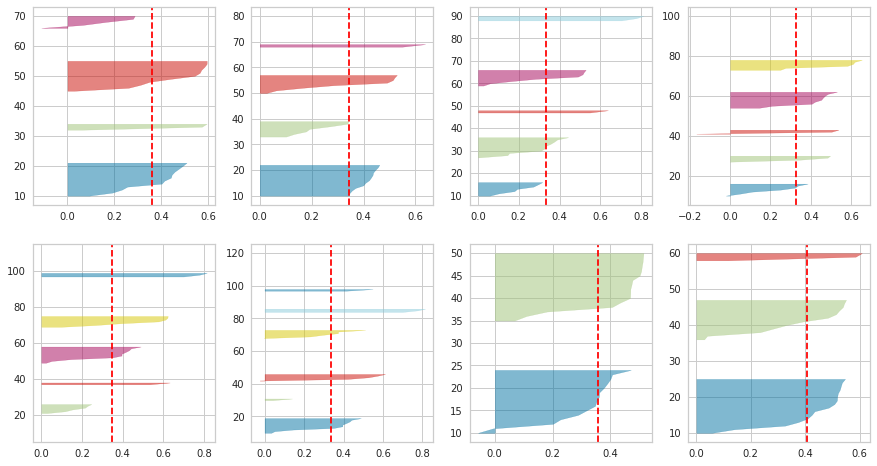

In [196]:
from yellowbrick.cluster import SilhouetteVisualizer
 
fig, ax = plt.subplots(2, 4, figsize=(15,8))
for i in range(2,10):
    '''
    Create KMeans instance for different number of clusters
    '''
    # km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 4)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(cluster[i], colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)  

In [197]:
k=3
X=df.loc[outlierIndex].copy()
X['cluster']=cluster[k].predict(X)
n=df.loc[[i for i in df.index if i not in outlierIndex]]
n['cluster']=k
new=pd.concat([X,n],axis=0)

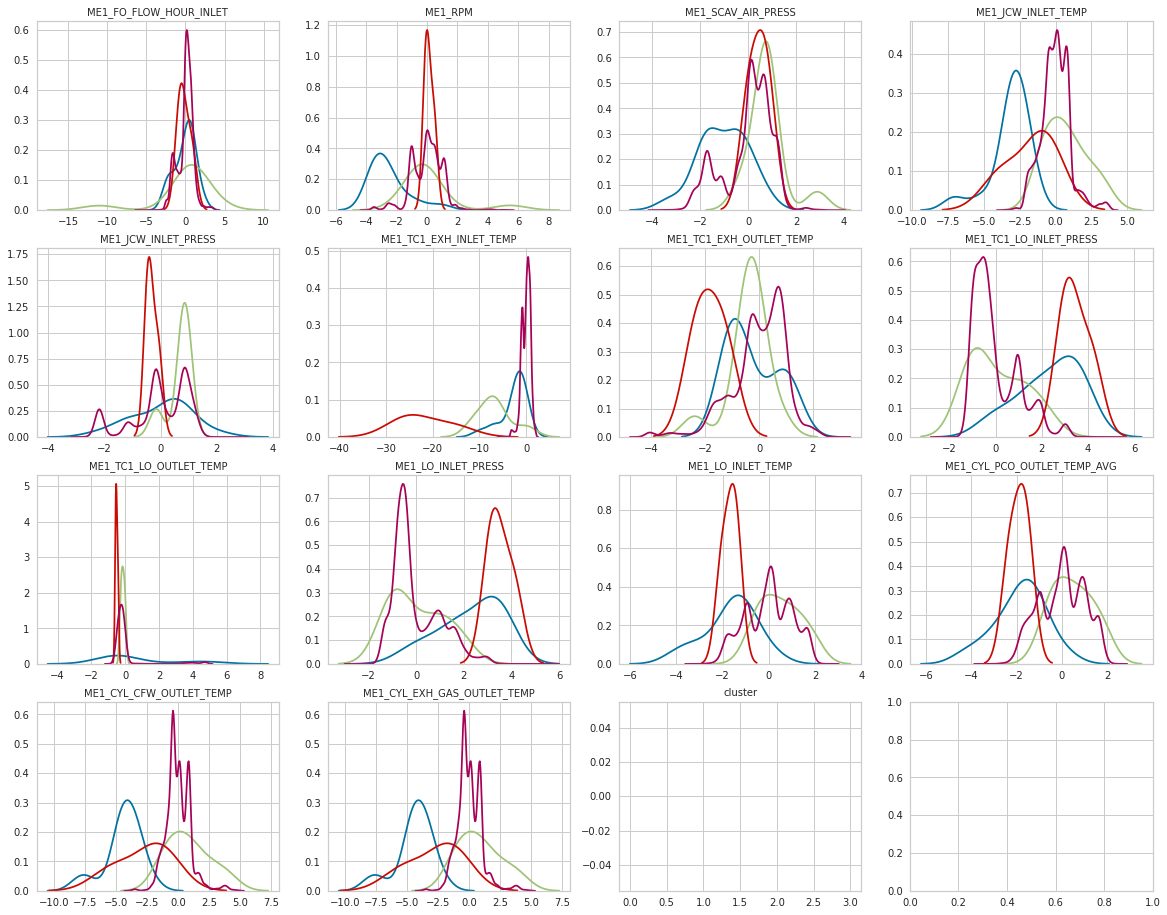

In [198]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

columns = df.columns
f, axes = plt.subplots(4, 4, figsize=(20, 16))
count=0
for c in X.columns:    
    i=count//4
    j=count%4    
    ax=axes[i,j]
    for i in range(k+1):
        sns.distplot(new[new['cluster']==i][c], kde=True, ax=ax,  norm_hist=True, hist=False)
    ax.set_title(c,  fontsize=10)
    ax.title.set_position((0.5,0.1))
    ax.set_ylabel('')    
    ax.set_xlabel('')


    count = count + 1

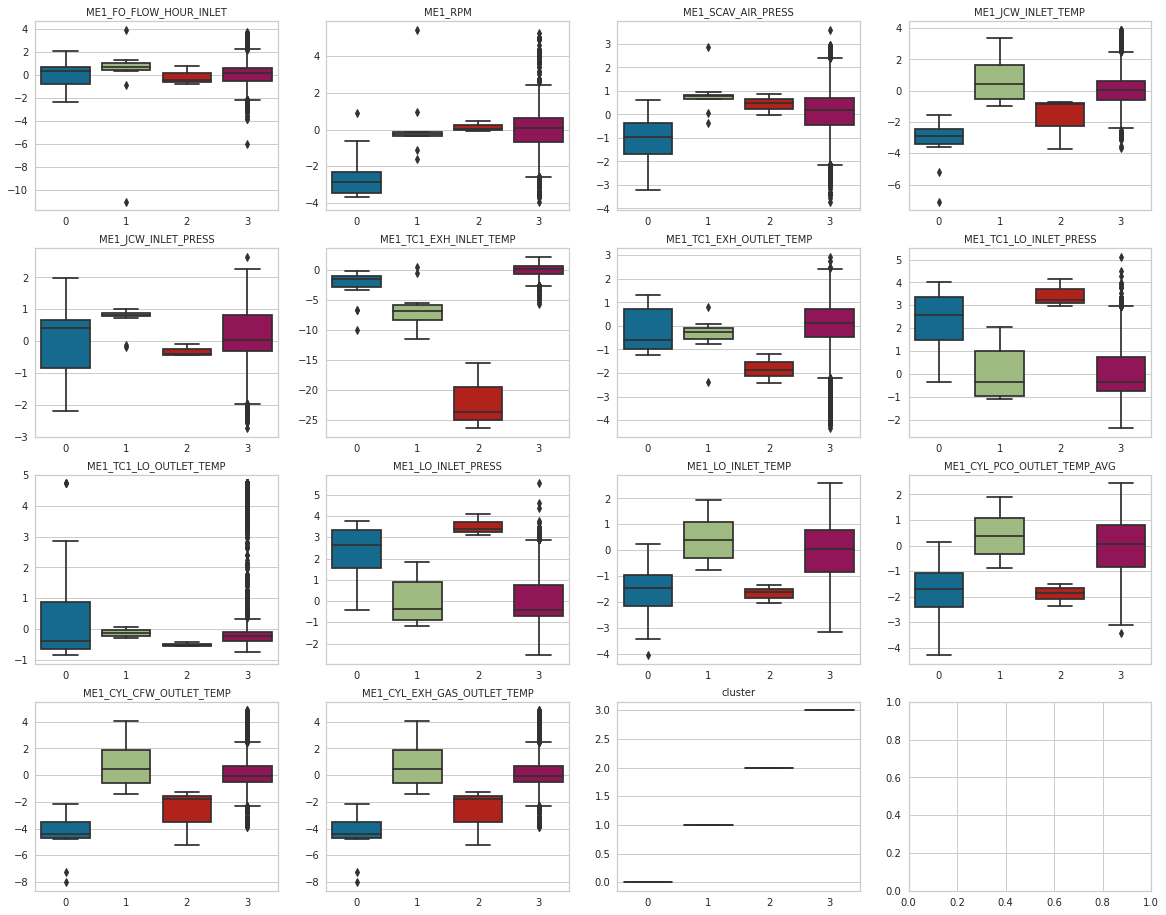

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns
columns = new.columns
f, axes = plt.subplots(4, 4, figsize=(20, 16))
count=0
for c in columns:    
    i=count//4
    j=count%4    
    ax=axes[i,j]
    sns.boxplot(x='cluster',y=c, data=new,ax=ax)
    ax.set_title(c,  fontsize=10)
    ax.title.set_position((0.5,0.1))
    ax.set_ylabel('')    
    ax.set_xlabel('')


    count = count + 1

In [201]:
raw=pd.read_csv('data/V7XJ9_10min.csv')
df_index=pd.read_csv('data/df4.csv',index_col=0)

In [202]:
outlierInfo=raw.iloc[df_index.iloc[outlierIndex].index][['TIME_STAMP','LAT','LON']]
outlierInfo['cluster']=cluster[k].labels_

In [203]:
outlierColor=['C'+str(i) for i in outlierInfo['cluster']]
outlierSize=clf.decision_scores_[outlierIndex]*10

In [204]:
markerDict=dict(zip(range(6),['^','v','o','x',',','+']))
outlierMarker=[markerDict[i] for i in outlierInfo['cluster']]

In [205]:
outlierInfo['cluster']

502      2
503      2
2977     2
2978     0
3633     1
5870     1
6833     0
7781     0
7784     1
8927     0
8928     0
8929     1
8930     1
8931     1
8932     1
8935     1
8937     1
8944     1
8955     1
10806    0
10820    0
10934    0
10935    0
10936    0
11000    0
13926    0
13927    0
13928    0
19740    0
19764    1
36713    0
Name: cluster, dtype: int32

<Figure size 10800x360 with 0 Axes>

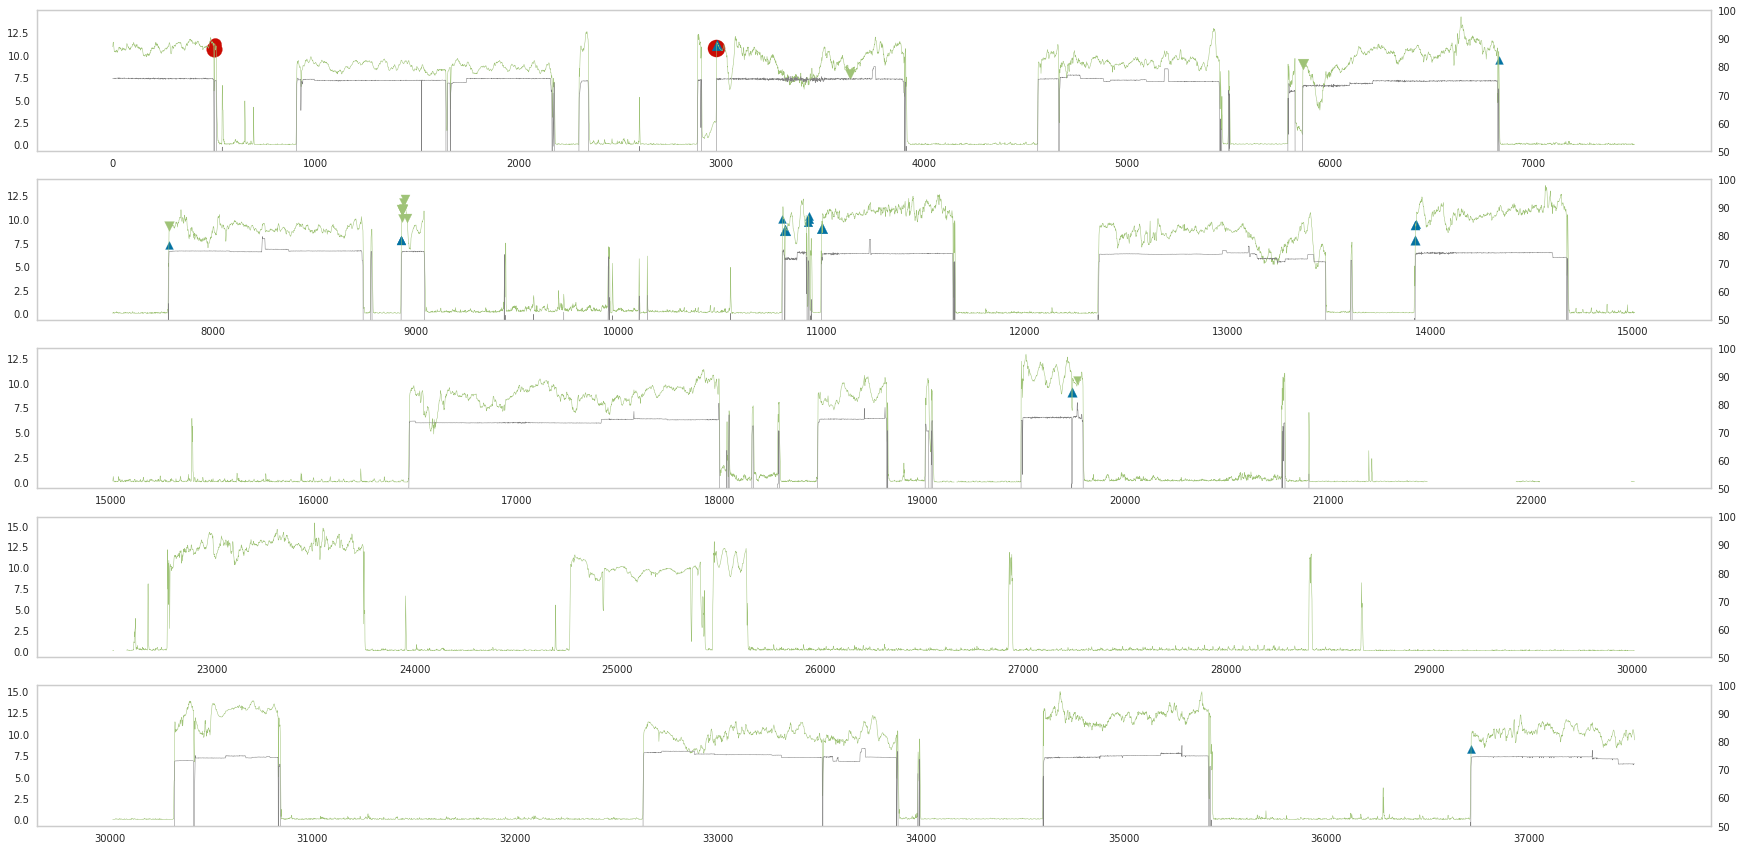

In [206]:
import matplotlib.pyplot as plt
plt.figure(figsize=(150,5))
f, axes = plt.subplots(5, 1, figsize=(30, 15))
batch_size=int(len(raw)/5)
axcount=0
for i in range(0,len(raw)-batch_size,batch_size):
    axes[axcount].grid(False)
    axes[axcount].plot(range(i,i+batch_size),raw.iloc[i:i+batch_size]['SPEED_VG'],c='C1',linewidth=0.5)
    ax2=axes[axcount].twinx()
    ax2.grid(False)
    ax2.set_ylim([50,100])
    ax2.plot(range(i,i+batch_size),raw.iloc[i:i+batch_size]['ME1_RPM'],c='grey',linewidth=0.5)
    tempIndex=outlierInfo.index
    temp_idx=tempIndex[(tempIndex<i+batch_size) & (tempIndex>=i)]
    temp_c=np.array(outlierColor)[(tempIndex<i+batch_size) & (tempIndex>=i)]
    temp_s=np.array(outlierSize)[(tempIndex<i+batch_size) & (tempIndex>=i)]
    temp_m=np.array(outlierMarker)[(tempIndex<i+batch_size) & (tempIndex>=i)]
    for i,m in zip(temp_idx,range(len(temp_idx))):       
        axes[axcount].scatter(i,raw.loc[i]['SPEED_VG'],c=temp_c[m],s=temp_s[m],marker=temp_m[m])
        
    #axes[axcount].scatter(temp_idx,raw.loc[temp_idx]['SPEED_VG'],c=temp_c,s=temp_s)
    axcount += 1

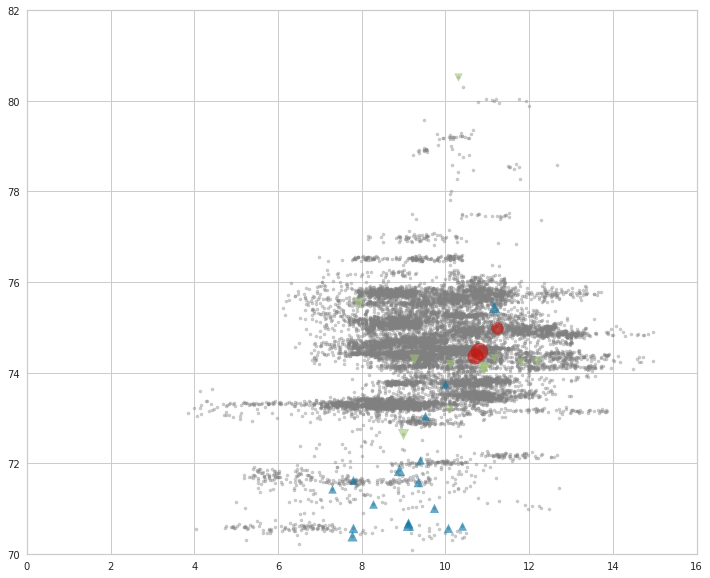

In [207]:
outlierInfo.index
plt.figure(figsize=(12,10))
plt.scatter(raw['SPEED_VG'],raw['ME1_RPM'],color='grey',s=10,alpha=0.4)
plt.ylim([70,82])
plt.xlim([0,16])
for o,i in zip(outlierInfo.index, range(len(outlierInfo.index))):
    x=raw.iloc[o]['SPEED_VG']
    y=raw.iloc[o]['ME1_RPM']
    plt.scatter(x,y,c=outlierColor[i],s=outlierSize[i],marker=outlierMarker[i],alpha=0.6)

In [34]:
# https://stackoverflow.com/questions/54613992/how-to-install-and-use-basemap-on-google-colab
# !apt-get install libgeos-3.5.0
# !apt-get install libgeos-dev
# !pip install https://github.com/matplotlib/basemap/archive/master.zip
# !pip install pyproj==1.9.6
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 69 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip (133.1 MB)
  Created wheel for basemap: filename=basemap-1.2.1-cp36-cp36m-linux_x86_64.whl size=121756166 sha256=02fa6f70655a487505563257e735598a9e237ede5c1cf476aac02c5195a5d625
  Stored in directory: /tmp/pip-ephem-wheel-cache-evx2b4eg/wheels/b2/eb/0c/9c11a58931f4e89206035c791d39a5ea9afe32dc43caa27538
Successfully built basemap
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via th

In [91]:
margin=10

lat=raw.iloc[df_index.index]['LAT'].values
lon=raw.iloc[df_index.index]['LON'].values

olat=outlierInfo['LAT'].values
olon=outlierInfo['LON'].values

lllat=lat.min()-margin
lllon=lon.min()-margin
urlat=lat.max()+margin
urlon=lon.max()+margin

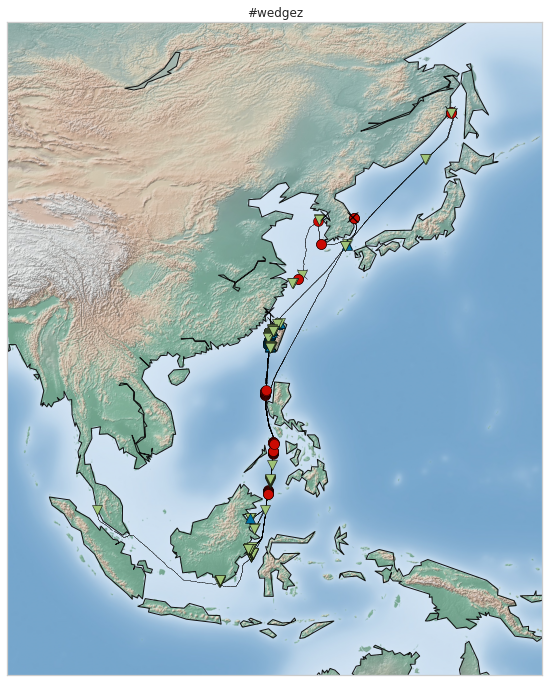

In [188]:
fig = plt.figure(figsize=(12, 12))
m = Basemap(projection='cyl', resolution='c',
            llcrnrlon=lllon,llcrnrlat=lllat,urcrnrlon=urlon,urcrnrlat=urlat)


x,y = m(lon, lat)
m.shadedrelief()
# m.bluemarble()
# m.fillcontinents(color="#FFDDCC", lake_color='#DDEEFF')
# m.drawmapboundary(fill_color="#DDEEFF")
m.drawcoastlines()
m.plot(x, y, 'o', markersize=0.5, c='black', alpha=0.6)
x,y = m(olon,olat)

# m.plot(x, y, '+', markersize=result['aomScore'][outlierIndex], c='red')
for x1,y1,oc,os,om in zip(olon,olat,outlierColor,np.log(outlierSize)*2,outlierMarker):
    m.plot(x1, y1, color=oc, marker=om, markersize=10, mew=0.5, mec='black')
plt.title("#wedgez")
plt.show() 

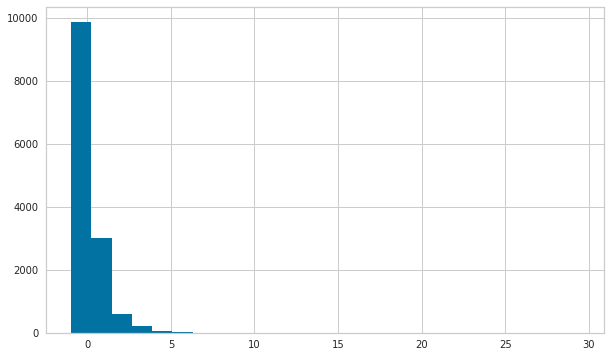

In [93]:
plt.figure(figsize=(10,6))
x,y,z=plt.hist(clf.decision_scores_,bins=25)

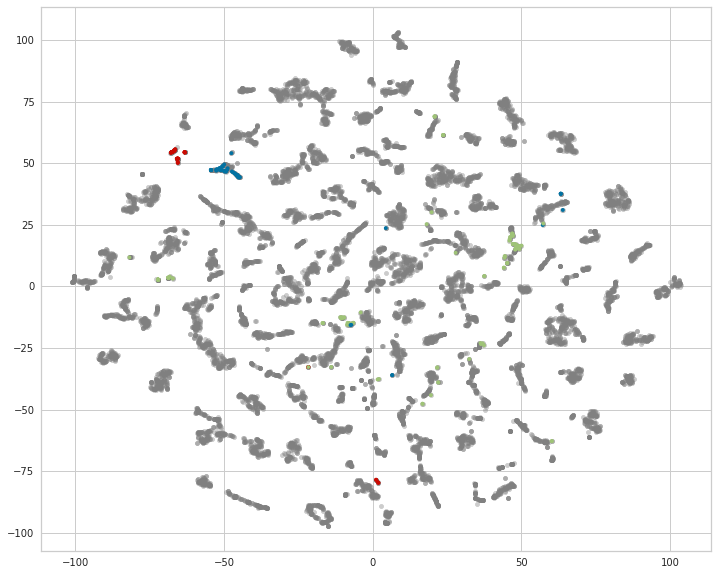

In [97]:
from sklearn.manifold import t_sne,TSNE
X_embedded = TSNE(n_components=2).fit_transform(df)


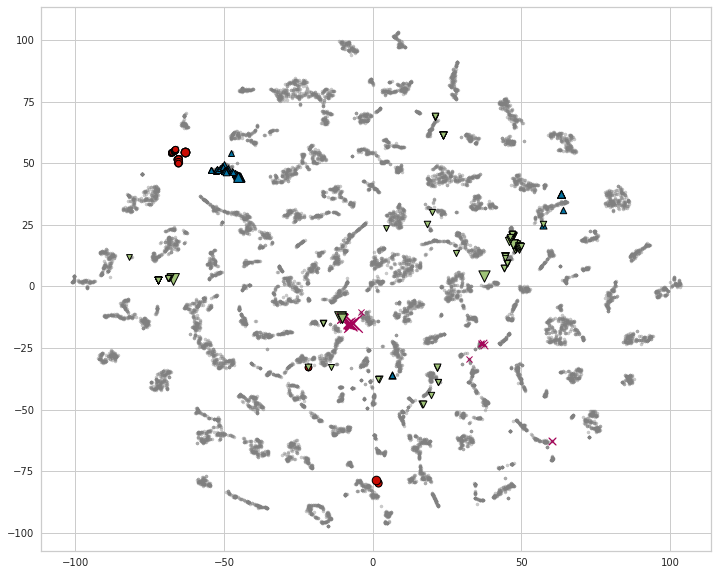

In [187]:
plt.figure(figsize=(12,10))
outlier_data=X_embedded[outlierIndex]
plt.scatter(X_embedded[:,0],X_embedded[:,1],c='grey',s=10, alpha=0.4)
for o,i in zip(outlierInfo.index, range(len(outlierInfo.index))):
    x=outlier_data[i,0]
    y=outlier_data[i,1]
    plt.scatter(x,y,c=outlierColor[i],s=outlierSize[i]*1.2,marker=outlierMarker[i], linewidths=1, edgecolors='black')
